### use autoencoder generate MNIST dataset 

In [1]:
__author__ = 'SherlockLiao'

### import necessary package

In [20]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### define function to transfer tensor to Variable or cuda.Variable

In [8]:
def to_var(x):
    x = Variable(x)
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x

### define function to transfer tensor to a image

In [9]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

### define hyperparameters

In [10]:
num_epochs = 70
batch_size = 128
learning_rate = 1e-3

### defein image dataset and image transforms

In [11]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### define MLP autoencoder

In [12]:
class MLPencoder(nn.Module):
    def __init__(self):
        super(MLPencoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [13]:
class MLPdecoder(nn.Module):
    def __init__(self):
        super(MLPdecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [14]:
if torch.cuda.is_available():
    en_model = MLPencoder().cuda()
    de_model = MLPdecoder().cuda()
else:
    en_model = MLPencoder()
    de_model = MLPdecoder()

### define loss and optimizer

In [15]:
parm = list(en_model.parameters()) + list(de_model.parameters())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parm, lr=learning_rate)

### train mlp autoencoder

In [16]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        num_img = img.size(0)
        img = img.view(num_img, -1)
        img = to_var(img)
        # ===================forward=====================
        code = en_model(img)
        output = de_model(code)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 20 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './img/image_{}.png'.format(epoch))

epoch [1/70], loss:0.1817
epoch [2/70], loss:0.1701
epoch [3/70], loss:0.1646
epoch [4/70], loss:0.1482
epoch [5/70], loss:0.1445
epoch [6/70], loss:0.1341
epoch [7/70], loss:0.1483
epoch [8/70], loss:0.1507
epoch [9/70], loss:0.1450
epoch [10/70], loss:0.1412
epoch [11/70], loss:0.1401
epoch [12/70], loss:0.1296
epoch [13/70], loss:0.1394
epoch [14/70], loss:0.1263
epoch [15/70], loss:0.1298
epoch [16/70], loss:0.1295
epoch [17/70], loss:0.1283
epoch [18/70], loss:0.1291
epoch [19/70], loss:0.1260
epoch [20/70], loss:0.1171
epoch [21/70], loss:0.1296
epoch [22/70], loss:0.1273
epoch [23/70], loss:0.1258
epoch [24/70], loss:0.1167
epoch [25/70], loss:0.1364
epoch [26/70], loss:0.1251
epoch [27/70], loss:0.1305
epoch [28/70], loss:0.1186
epoch [29/70], loss:0.1150
epoch [30/70], loss:0.1249
epoch [31/70], loss:0.1184
epoch [32/70], loss:0.1225
epoch [33/70], loss:0.1244
epoch [34/70], loss:0.1202
epoch [35/70], loss:0.1259
epoch [36/70], loss:0.1144
epoch [37/70], loss:0.1354
epoch [38/

### save model

In [17]:
torch.save(en_model.state_dict(), './encoder.pth')
torch.save(de_model.state_dict(), './decoder.pth')

### load model

In [18]:
en_model.load_state_dict(torch.load('./encoder.pth'))
de_model.load_state_dict(torch.load('./decoder.pth'))

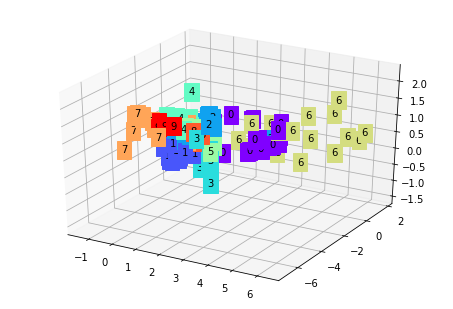

In [21]:
view_data = Variable(dataset.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255).cuda()
code = en_model(view_data)
code = code.cpu()
fig = plt.figure(2)
ax = Axes3D(fig)    # 3D 图
# x, y, z 的数据值
X = code.data[:, 0].numpy()
Y = code.data[:, 1].numpy()
Z = code.data[:, 2].numpy()
values = dataset.train_labels[:200].numpy()  # 标签值
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9))    # 上色
    ax.text(x, y, z, s, backgroundcolor=c)  # 标位子
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

### given a random code to generate image

In [ ]:
code = to_var(torch.Tensor([4, 2.3, -0.4]))
code = code.unsqueeze(0)
out = de_model(code)
img = to_img(out)
a = transforms.ToPILImage()(img.cpu().data.squeeze(0))
a.resize((100, 100))

### define deep convolution autoencoder

In [ ]:
class DCautoencoder(nn.Module):
    def __init__(self):
        super(DCautoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
if torch.cuda.is_available():
    dc_autoencoder = DCautoencoder().cuda()
else:
    dc_autoencoder = DCautoencoder()

### define loss and optimizer

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dc_autoencoder.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = to_var(img)
        # ===================forward=====================
        output = dc_autoencoder(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 20 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './img/image_{}.png'.format(epoch))

### save model

In [ ]:
torch.save(dc_autoencoder.state_dict(), './dc_autoencoder.pth')